# Our question: How well does energy consumed by a building relate to the number of units in the building?

In [1]:
import geopandas as gp
import pandas as pd
import os
import json
import urllib as ulr
import pylab as pl
import zipfile as zp
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def getData(string):
    print ("Downloading", string)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + '/' + string ):
        if os.path.isfile(string):
            # if in the current dir just move it
            if os.system("mv " + string + ' ' + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            os.system("curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv")
            ###  To move it I use the os.system() functions to run bash commands with arguments
            os.system("mv " + string + ' ' + os.getenv("PUIDATA"))
            
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + string):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
getData("rows.csv")

('Downloading', 'rows.csv')
file in place, you can continue


In [4]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/rows.csv")
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c24c91c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8bffe00ed0>]], dtype=object)

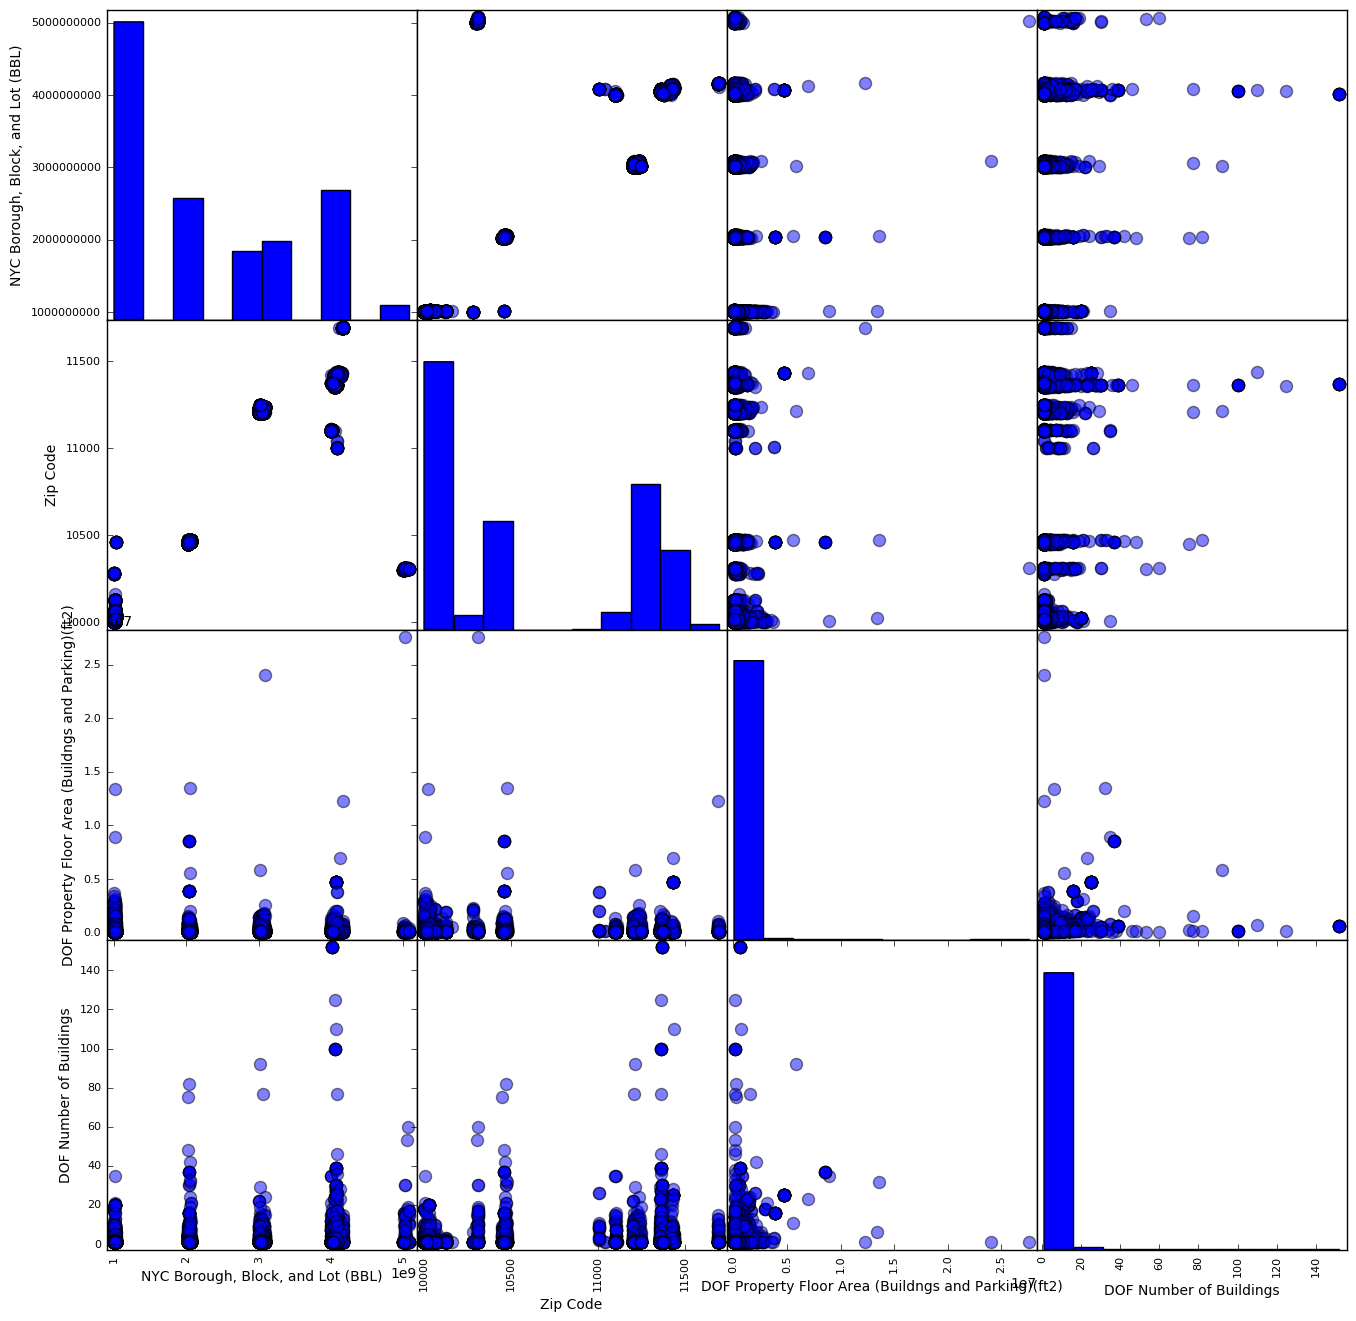

In [5]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16))

In [6]:
nrg.drop([u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'], axis=1, inplace=True)
# nrg.drop([u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)'], axis=1)
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Site EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Reported Property Floor Area (Building(s)) (ft²)'],
      dtype='object')

In [7]:
nrg.drop('Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)', axis=1, inplace=True)

In [8]:
nrg.dropna(inplace=True)

In [9]:
nrg.head()

,"NYC Borough, Block, and Lot (BBL)",Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
3028,1.013110e+09,125.4,330000
12140,2.022150e+09,6224.5,342048
15011,1.010140e+09,154.9,841709
9863,4.002520e+09,46,390400
12237,4.004370e+09,66.2,528060


In [10]:
def getdata2(string):
    print ("Downloading", string)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + '/' + string ):
        if os.path.isfile(string):
            # if in the current dir just move it
            if os.system("mv " + string + ' ' + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            os.system("curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip")
            zf = zp.ZipFile('mn_mappluto_16v1.zip')
            zf.extractall(os.getenv('PUIDATA'))
            zf.close()
            ###  To move it I use the os.system() functions to run bash commands with arguments
            os.system("mv " + string + ' ' + os.getenv("PUIDATA"))
            os.system('rm MN*' )
            
            
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + string):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [11]:
getdata2('MNMapPLUTO.shp')

('Downloading', 'MNMapPLUTO.shp')
file in place, you can continue


In [12]:
bsize = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/' + "MNMapPLUTO.shp")
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [13]:
bsize.drop([u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
         u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidFAR',
       u'RetailArea', u'SHAPE_Area', u'SHAPE_Leng',    u'SPDist1',
          u'SPDist2',    u'Sanborn',  u'SanitBoro',  u'SanitDist',
         u'SanitSub', u'SchoolDist',  u'SplitZone',  u'StrgeArea',
           u'TaxMap',  u'Tract2010',
          u'Version',     u'XCoord',     u'YCoord', u'YearAlter1',
       u'YearAlter2',  u'YearBuilt',     u'ZMCode',    u'ZipCode',
        u'ZoneDist1',  u'ZoneDist2',  u'ZoneDist3',  u'ZoneDist4',
          u'ZoneMap',   u'geometry'], axis=1, inplace=True)

In [14]:
bsize.head()

,BBL,UnitsRes,UnitsTotal
0,1.015450e+09,16,18
1,1.007238e+09,50,50
2,1.016800e+09,10,10
3,1.013850e+09,29,32
4,1.011970e+09,26,26


In [15]:
nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)': 'BBL'}, inplace=True)
bblnrgdata = pd.merge(nrg, bsize, on='BBL')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


In [16]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal
0,1.013110e+09,125.4,330000,0,56
1,1.010140e+09,154.9,841709,0,2
2,1.007660e+09,122.3,59468,0,8
3,1.008150e+09,117,364000,0,24
4,1.005050e+09,82.1,235370,0,24


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c1a413210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8bca4dae50>]], dtype=object)

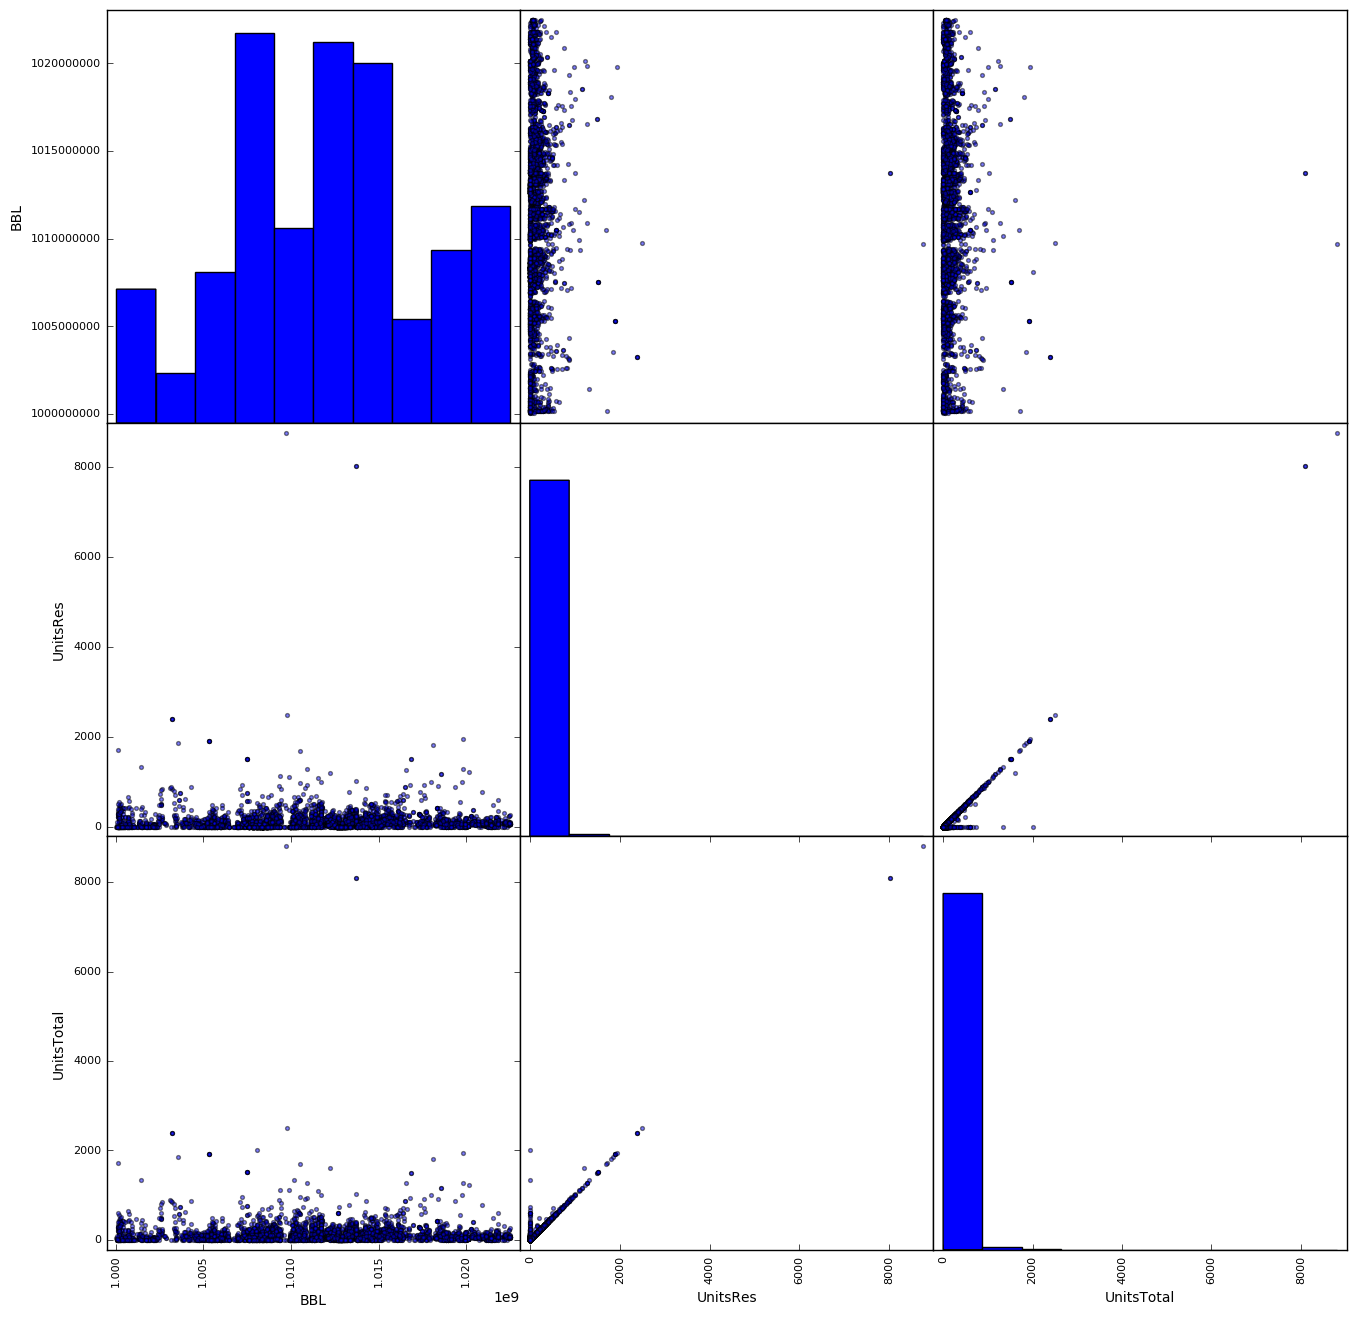

In [17]:
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

In [18]:
def canconvert(mydata):
    """
    This functions checks if data values can be converted to a float
    """
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [19]:
def makeBooleanColumn(dataframe, df_column):
    """
    This function checks if values of a colunm in a given dataframe are floats or not
    returns a list a boolean values corresponding to the column supplied
    """
    column_in_matrix_form = pd.Series.as_matrix(dataframe[df_column])
    new_list = []
    for i in range (0, len(dataframe)):
        new_list.append(canconvert(column_in_matrix_form[i]))
    return new_list

In [20]:
bblnrgdata['EUI_index'] = makeBooleanColumn(bblnrgdata, 'Site EUI(kBtu/ft2)')
bblnrgdata['feet_index'] = makeBooleanColumn(bblnrgdata, 'Reported Property Floor Area (Building(s)) (ft²)')
bblnrgdata['UnitsResIndex'] = makeBooleanColumn(bblnrgdata, 'UnitsRes')
bblnrgdata['UnitsTotalIndex'] = makeBooleanColumn(bblnrgdata, 'UnitsTotal')

In [21]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,EUI_index,feet_index,UnitsResIndex,UnitsTotalIndex
0,1.013110e+09,125.4,330000,0,56,True,True,True,True
1,1.010140e+09,154.9,841709,0,2,True,True,True,True
2,1.007660e+09,122.3,59468,0,8,True,True,True,True
3,1.008150e+09,117,364000,0,24,True,True,True,True
4,1.005050e+09,82.1,235370,0,24,True,True,True,True


In [22]:
bblnrgdata.columns

Index([                                             u'BBL',
                                     u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
                                               u'UnitsRes',
                                             u'UnitsTotal',
                                              u'EUI_index',
                                             u'feet_index',
                                          u'UnitsResIndex',
                                        u'UnitsTotalIndex'],
      dtype='object')

In [23]:
bblnrgdata = bblnrgdata[(bblnrgdata.EUI_index == True) & (bblnrgdata.feet_index == True) 
         & (bblnrgdata.UnitsResIndex == True) & (bblnrgdata.UnitsTotalIndex == True) ]

bblnrgdata.drop([u'EUI_index',  u'feet_index', u'UnitsResIndex', u'UnitsTotalIndex'] ,
             axis = 1, inplace = True)

In [24]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal
0,1.013110e+09,125.4,330000,0,56
1,1.010140e+09,154.9,841709,0,2
2,1.007660e+09,122.3,59468,0,8
3,1.008150e+09,117,364000,0,24
4,1.005050e+09,82.1,235370,0,24


In [25]:
bblnrgdata['TotalEnergy'] = (bblnrgdata['Site EUI(kBtu/ft2)'].astype(float) * bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float))

In [46]:
# taking out zero values (as outliers)
bblnrgdata = bblnrgdata[(bblnrgdata.UnitsTotal > 10) & (bblnrgdata.TotalEnergy > 1000) & (bblnrgdata.UnitsTotal < 1000)]
len(bblnrgdata)

4237

In [48]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,TotalEnergy,UnitsTotalSQR
0,1.013110e+09,125.4,330000,0,56,41382000.0,3136
3,1.008150e+09,117,364000,0,24,42588000.0,576
4,1.005050e+09,82.1,235370,0,24,19323877.0,576
5,1.021420e+09,137.69999999999999,64806,54,62,8923786.2,3844
6,1.021750e+09,103.2,62839,75,85,6484984.8,7225


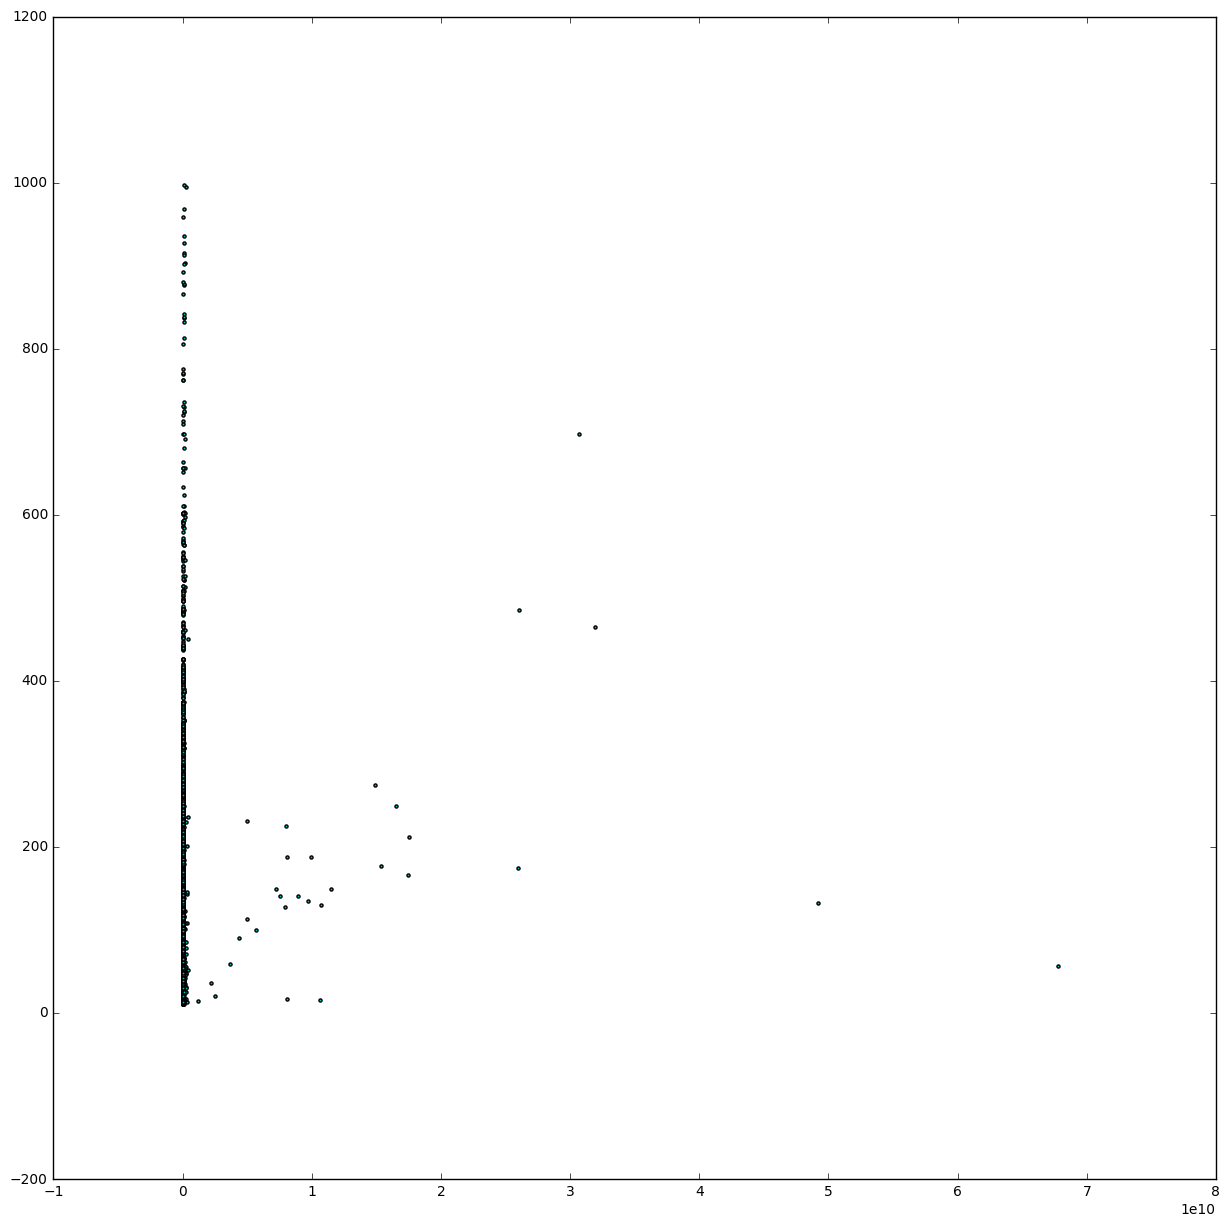

In [166]:
pl.figure(figsize=(15,15))
pl.scatter(bblnrgdata['TotalEnergy'], bblnrgdata['UnitsTotal'], s=5, c='c')

[1000, 10000000000.0, 0, 1000]

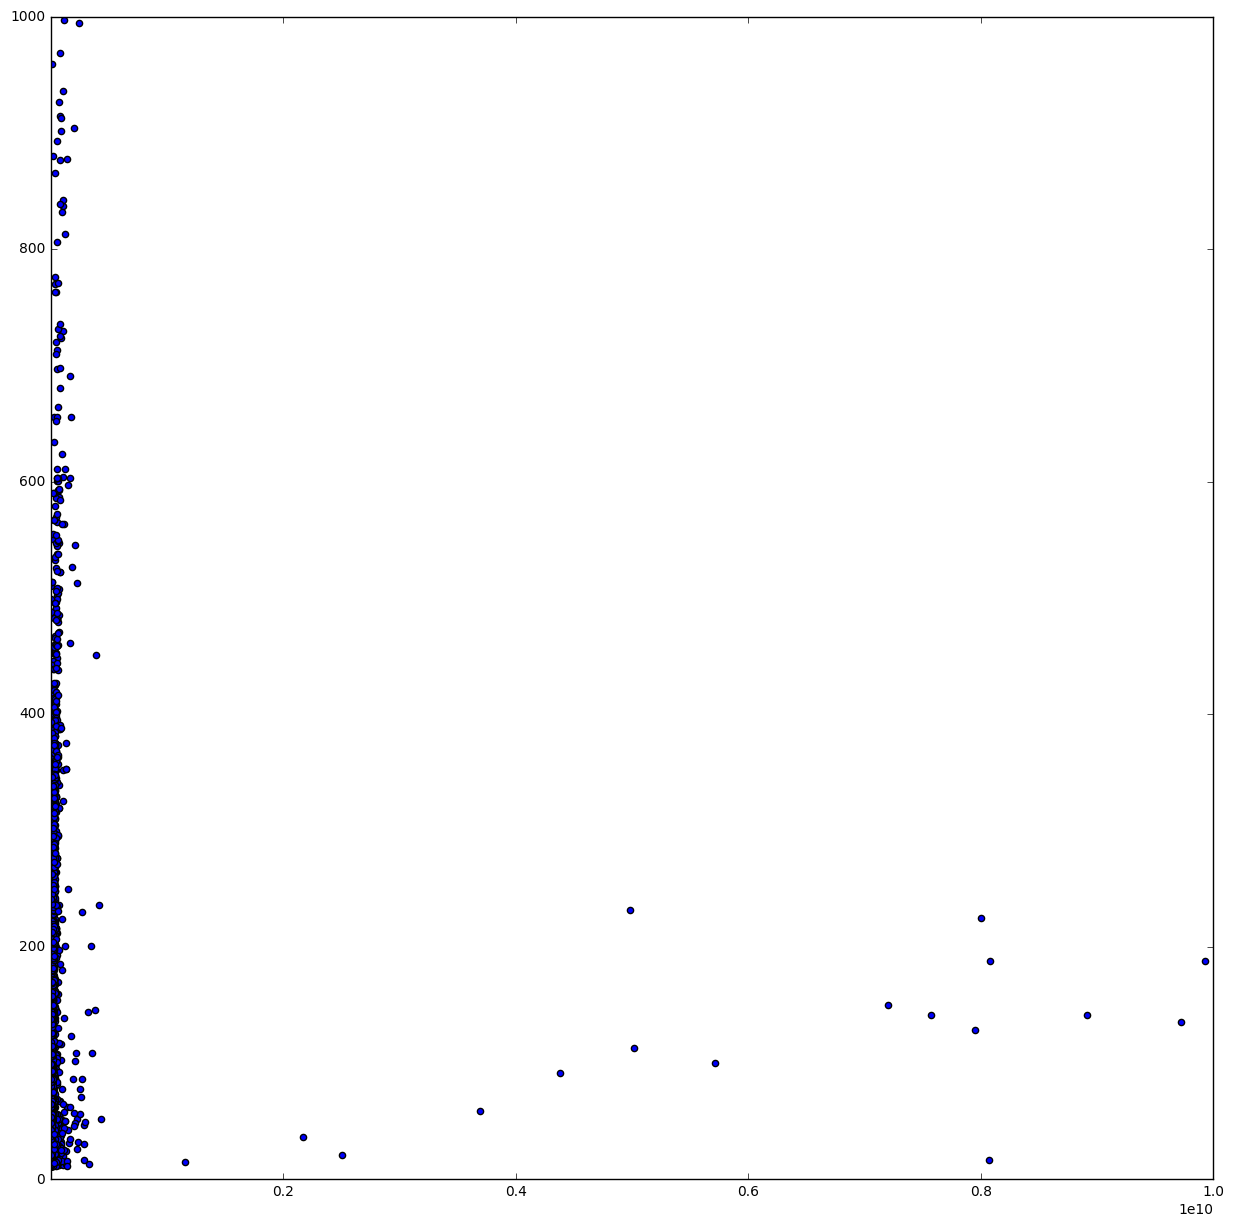

In [167]:
# zoomed plot
pl.figure(figsize=(15,15))
pl.scatter(bblnrgdata['TotalEnergy'], bblnrgdata['UnitsTotal'])
pl.axis([1000, 1e10, 0, 1000])

### plotting log model

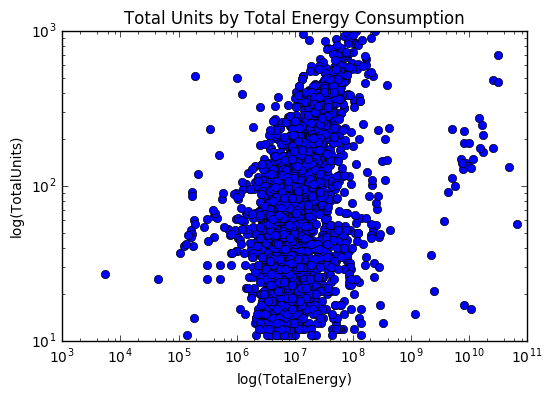

In [168]:
pl.loglog(bblnrgdata['TotalEnergy'], bblnrgdata['UnitsTotal'], 'bo')
pl.xlabel('log(TotalEnergy)')
pl.ylabel('log(TotalUnits)')
pl.title("Total Units by Total Energy Consumption")

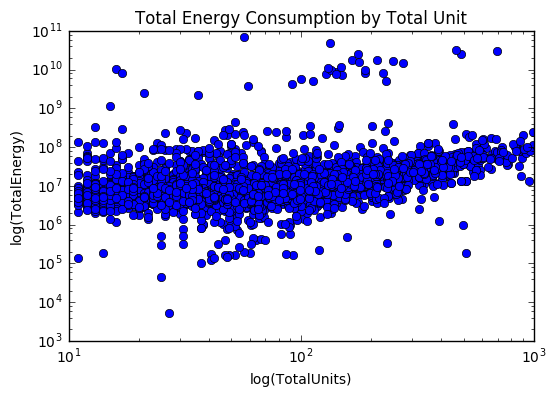

In [169]:
pl.loglog(bblnrgdata['UnitsTotal'], bblnrgdata['TotalEnergy'], 'bo')
pl.xlabel('log(TotalUnits)')
pl.ylabel('log(TotalEnergy)')
pl.title("Total Energy Consumption by Total Unit")

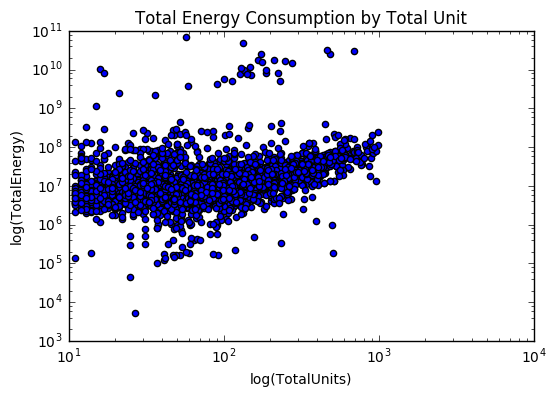

In [170]:
# another way to plot
bblnrgdata.plot.scatter('UnitsTotal', 'TotalEnergy', loglog=True)
pl.xlabel('log(TotalUnits)')
pl.ylabel('log(TotalEnergy)')
pl.title("Total Energy Consumption by Total Unit")

In [138]:
lm = smf.ols(formula= 'log(TotalEnergy) ~ log(UnitsTotal)', data=bblnrgdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log(TotalEnergy)   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     848.0
Date:                Mon, 17 Oct 2016   Prob (F-statistic):          4.23e-170
Time:                        16:52:30   Log-Likelihood:                -6066.0
No. Observations:                4237   AIC:                         1.214e+04
Df Residuals:                    4235   BIC:                         1.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          14.0025      0.077    182.547      0.000        13.852    14.153
log(UnitsTotal)     0.5024      0.017     29.121      0.000         0.469     0.536
==============================================================================
Omnibus:                     2273.853   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46297.723
Skew:                           2.111   Prob(JB):                         0.00
Kurtosis:                      18.634   Cond. No.                         23.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

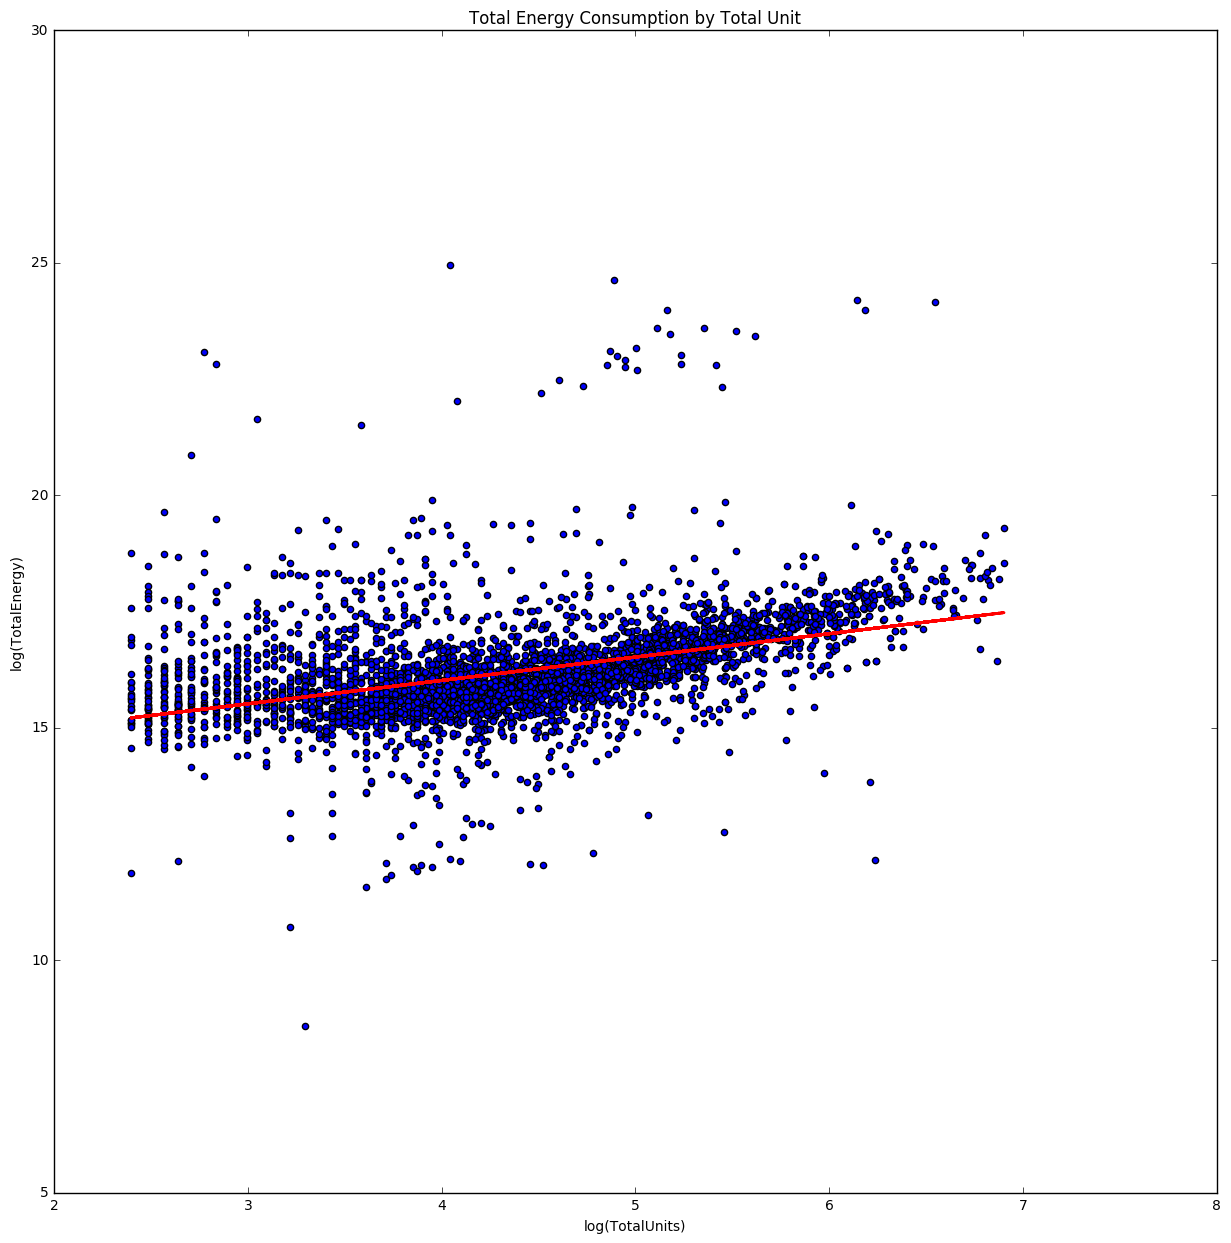

In [165]:
pl.figure(figsize=(15,15))
pl.scatter(log(bblnrgdata['UnitsTotal']), log(bblnrgdata['TotalEnergy']))
pl.xlabel('log(TotalUnits)')
pl.ylabel('log(TotalEnergy)')
pl.title("Total Energy Consumption by Total Unit")
y_fit = lm.predict(bblnrgdata)
pl.plot(log(bblnrgdata['UnitsTotal']),y_fit,'--b', color = 'red', linewidth = 2)

In [140]:
lm2 = smf.ols(formula= 'log(UnitsTotal) ~ log(TotalEnergy)', data=bblnrgdata).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log(UnitsTotal)   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     848.0
Date:                Mon, 17 Oct 2016   Prob (F-statistic):          4.23e-170
Time:                        16:52:34   Log-Likelihood:                -5188.7
No. Observations:                4237   AIC:                         1.038e+04
Df Residuals:                    4235   BIC:                         1.039e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -1.0225      0.185     -5.526      0.000        -1.385    -0.660
log(TotalEnergy)     0.3321      0.011     29.121      0.000         0.310     0.354
==============================================================================
Omnibus:                      130.662   Durbin-Watson:                   1.369
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.961
Skew:                          -0.431   Prob(JB):                     9.05e-32
Kurtosis:                       3.261   Cond. No.                         238.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

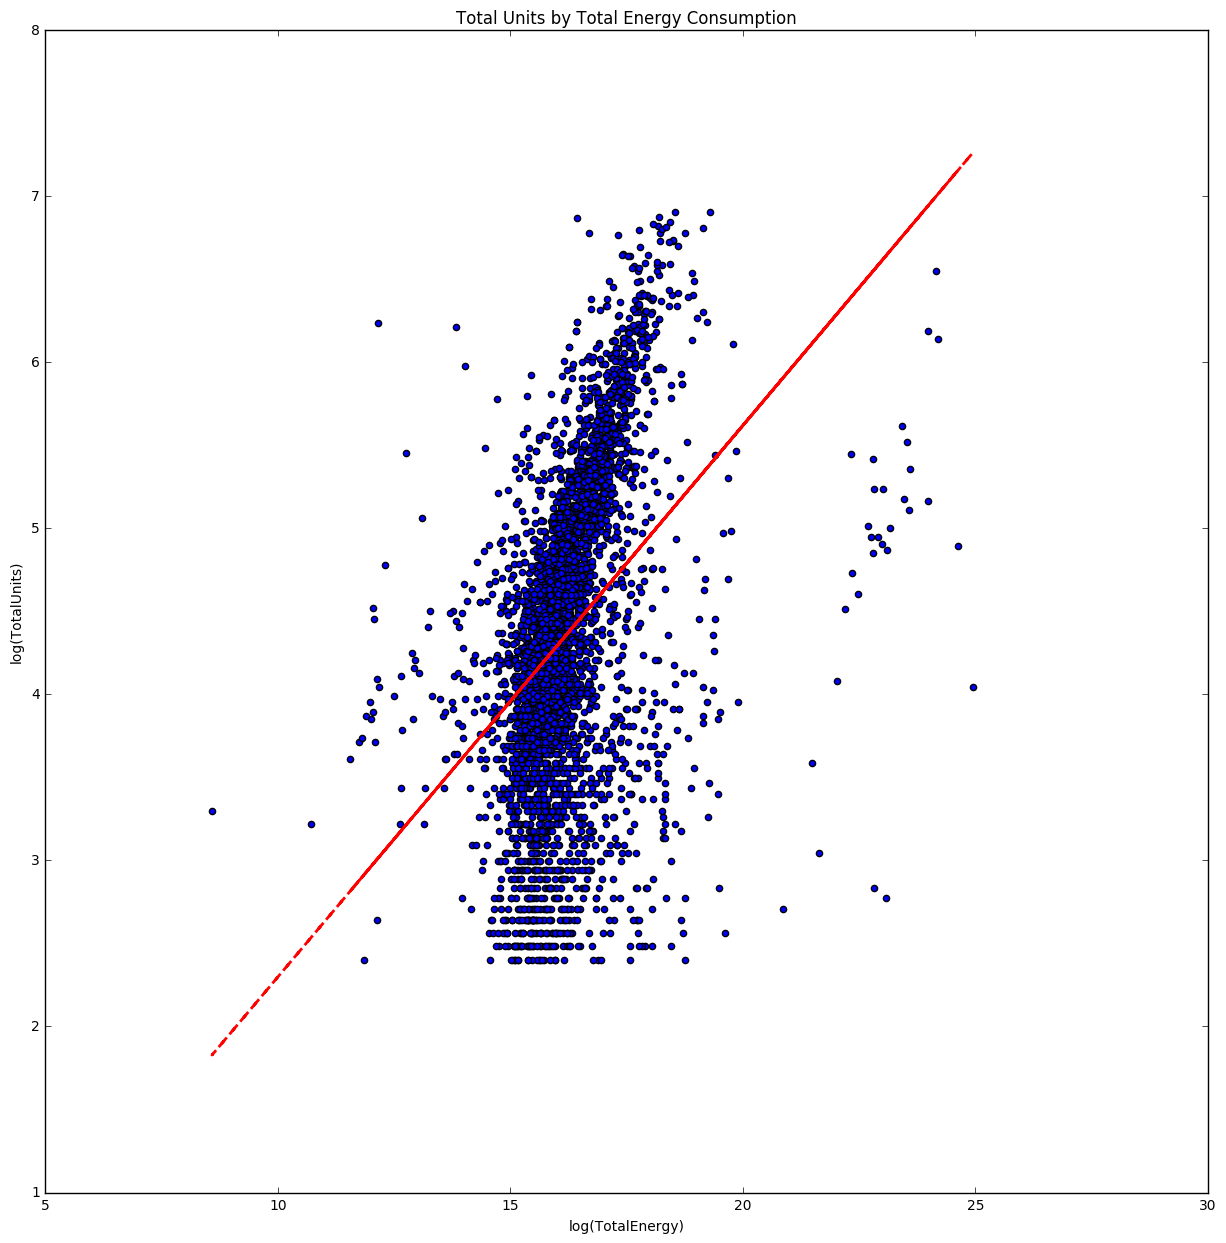

In [164]:
pl.figure(figsize=(15,15))
pl.scatter(log(bblnrgdata['TotalEnergy']), log(bblnrgdata['UnitsTotal']))
pl.xlabel('log(TotalEnergy)')
pl.ylabel('log(TotalUnits)')
pl.title("Total Units by Total Energy Consumption")
y_fit2 = lm2.predict(bblnrgdata)
pl.plot(log(bblnrgdata['TotalEnergy']),y_fit2,'--b', color = 'red', linewidth = 2)

## Chi square

In [142]:
sum(((y_fit - log(bblnrgdata['TotalEnergy']))**2) / (log(np.sqrt(log(bblnrgdata.TotalEnergy))))**2)

2134.6277627717982

In [143]:
sum(((y_fit2 - log(bblnrgdata['UnitsTotal']))**2) / (log(np.sqrt(log(bblnrgdata.UnitsTotal))))**2)

7320.4613709859987

#### The first one is better according to the chi square test

## 2nd degree polynomial

In [144]:
bblnrgdata['UnitsTotalSquare'] = bblnrgdata['UnitsTotal']**2
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,TotalEnergy,UnitsTotalSquare
0,1.013110e+09,125.4,330000,0,56,41382000.0,3136
3,1.008150e+09,117,364000,0,24,42588000.0,576
4,1.005050e+09,82.1,235370,0,24,19323877.0,576
5,1.021420e+09,137.69999999999999,64806,54,62,8923786.2,3844
6,1.021750e+09,103.2,62839,75,85,6484984.8,7225


In [145]:
lm3 = smf.ols(formula= 'log(TotalEnergy) ~ log(UnitsTotal) + I(log(UnitsTotalSquare))', data = bblnrgdata).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log(TotalEnergy)   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     848.0
Date:                Mon, 17 Oct 2016   Prob (F-statistic):          4.23e-170
Time:                        16:52:47   Log-Likelihood:                -6066.0
No. Observations:                4237   AIC:                         1.214e+04
Df Residuals:                    4235   BIC:                         1.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   14.0025      0.077    182.547      0.000        13.852    14.153
log(UnitsTotal)              0.1005      0.003     29.121      0.000         0.094     0.107
I(log(UnitsTotalSquare))     0.2010      0.007     29.121      0.000         0.187     0.214
==============================================================================
Omnibus:                     2273.853   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46297.723
Skew:                           2.111   Prob(JB):                         0.00
Kurtosis:                      18.634   Cond. No.                     7.78e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.99e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

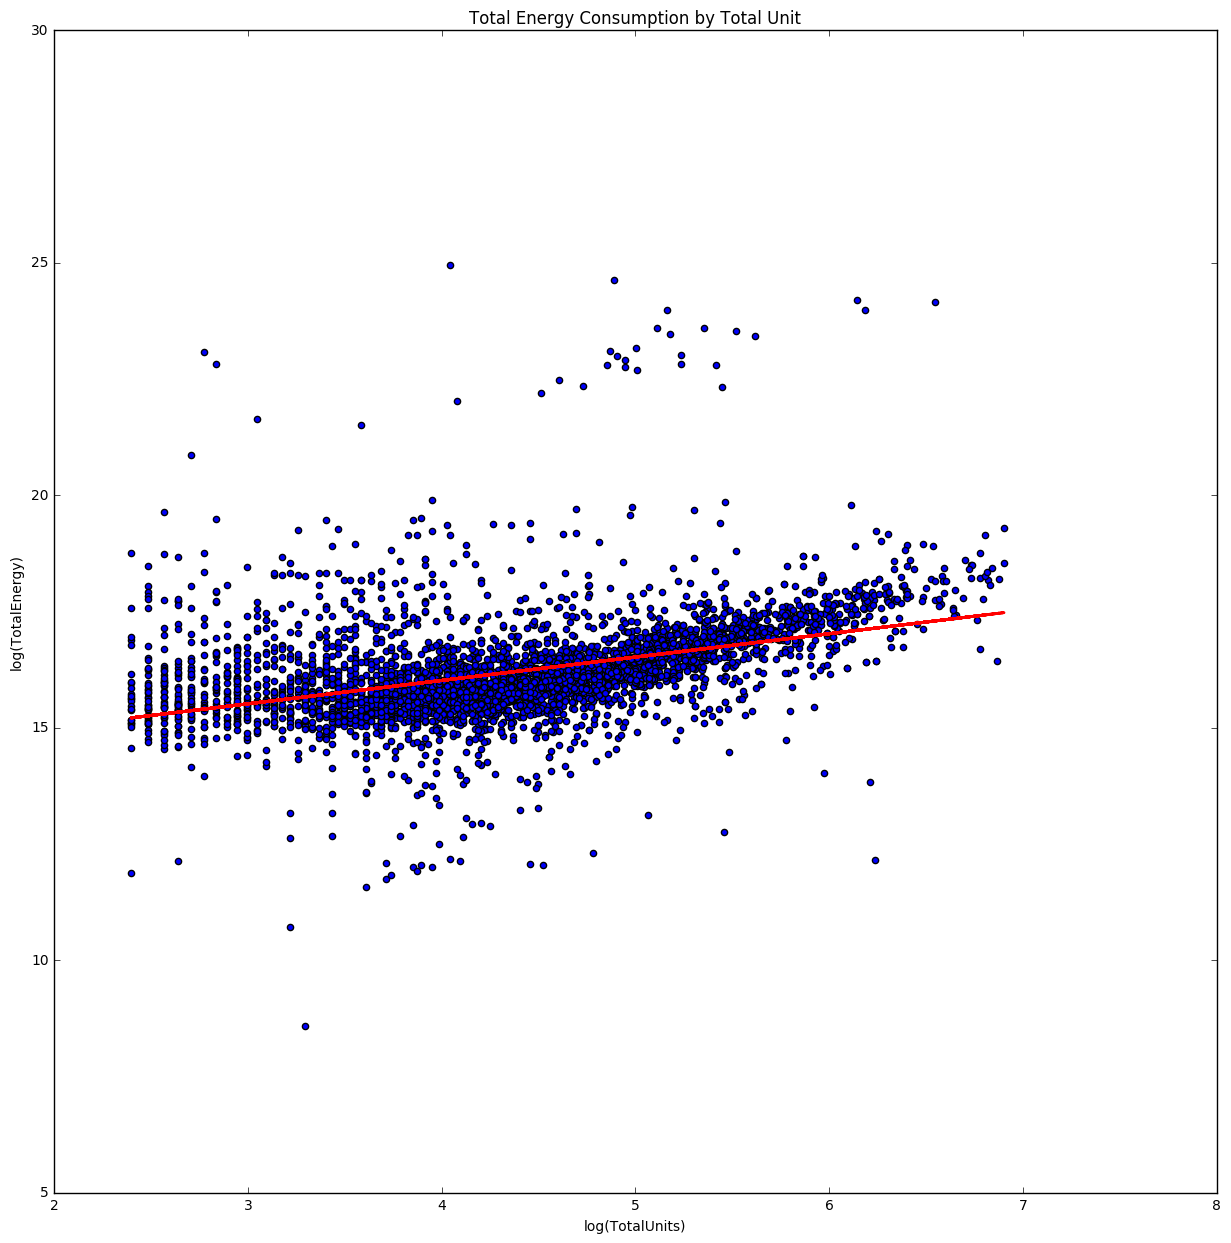

In [160]:
pl.figure(figsize=(15,15))
pl.scatter(log(bblnrgdata['UnitsTotal']), log(bblnrgdata['TotalEnergy']))
pl.xlabel('log(TotalUnits)')
pl.ylabel('log(TotalEnergy)')
pl.title("Total Energy Consumption by Total Unit")
y_fit3 = lm3.predict(bblnrgdata)
plt.plot(log(bblnrgdata['UnitsTotal']),y_fit3,'--b', color = 'red', linewidth = 2)

In [ ]:
# code from Kristi Korsberg
xp = np.linspace(2, 7, 100)
coefs = np.polyfit(log(bblnrgdata['UnitsTotal']), log(bblnrgdata['TotalEnergy']), 2)
fit = np.poly1d(coefs)

pl.figure(figsize=(15,15))
pl.plot(log(bblnrgdata['UnitsTotal']), log(bblnrgdata['TotalEnergy']), 'b.')
pl.plot(xp, fit(xp), color = 'red', linewidth = 2)
pl.ylabel("Total Energy")
pl.xlabel("Total Units")
pl.title("Total Energy Consumption by Total Unit")

In [147]:
X = sm.add_constant(log(bblnrgdata['UnitsTotal']))
linmodel = sm.OLS(log(bblnrgdata['TotalEnergy']), X, missing='drop').fit()

In [149]:
lm_logLikelyhood = -3867.6 #according to lm.summary()
lm3_logLikelyhood = -3867.6 #according to lm3.summary()
LR = -2*(lm_logLikelyhood-lm3_logLikelyhood)
print "LR = %d" %LR

LR = 0


In [92]:
smf.ols(formula ='log(TotalEnergy) ~ log(UnitsTotal) + log(UnitsTotalSQR)', 
        data = bblnrgdata).fit().compare_lr_test(sm.OLS(formula='log(TotalEnergy) ~ log(UnitsTotal)', 
                                                        data=bblnrgdata)).fit()

TypeError: __init__() takes at least 2 arguments (1 given)

In [ ]:
#slope, intercept, r_value, p_value, slope_std_error = scipy.stats.linregress(log(bblnrgdata['UnitsTotal']), log(bblnrgdata['TotalEnergy']))
#y_predict = intercept + log(bblnrgdata['UnitsTotal'])